In [2]:
import geopandas as gpd
import pandas as pd
from shapely import wkt
import keplergl
from tqdm import tqdm
import matplotlib.pyplot as plt
import h3
import re
from geopy import Nominatim, location
from geopy.extra.rate_limiter import RateLimiter
import googlemaps

In [3]:
# Load both datasets
houses = pd.read_csv('datasets/base_data/houses_Madrid.csv')
airbnb = pd.read_csv('datasets/base_data/listings_detailed.csv')

<h3>First we modify houses dataframe</h3>

In [4]:
# Creating full address and geocoding (lat/long) for visualization purposes
# Full Address
houses['title'] = houses['title'].str.replace('Piso en venta en ', '')
houses['full_title'] = houses['title']+', '+houses['subtitle']

In [5]:
# Creating new column with the normalized district name to find zip codes
houses['subtitle'] = houses['subtitle'].str.replace(', Madrid', '')
houses['subtitle'] = houses['subtitle'].str.upper()
houses['subtitle'] = houses['subtitle'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
houses.head()

,Unnamed: 0,id,title,subtitle,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,...,has_parking,has_private_parking,has_public_parking,is_parking_included_in_price,parking_price,is_orientation_north,is_orientation_west,is_orientation_south,is_orientation_east,full_title
0,0,21742,"calle de Godella, 64",SAN CRISTOBAL,64.0,60.0,2,1.0,NaN,NaN,...,False,NaN,NaN,NaN,NaN,False,True,False,False,"calle de Godella, 64, San Cristóbal, Madrid"
1,1,21741,calle de la del Manojo de Rosas,LOS ANGELES,70.0,NaN,3,1.0,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"calle de la del Manojo de Rosas, Los Ángeles, ..."
2,2,21740,"calle del Talco, 68",SAN ANDRES,94.0,54.0,2,2.0,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"calle del Talco, 68, San Andrés, Madrid"
3,3,21739,calle Pedro Jiménez,SAN ANDRES,64.0,NaN,2,1.0,NaN,NaN,...,False,NaN,NaN,NaN,NaN,False,False,True,False,"calle Pedro Jiménez, San Andrés, Madrid"
4,4,21738,carretera de Villaverde a Vallecas,LOS ROSALES,108.0,90.0,2,2.0,NaN,NaN,...,True,NaN,NaN,True,0.0,True,True,True,True,"carretera de Villaverde a Vallecas, Los Rosale..."


In [6]:
# Zip codes
barrios = pd.read_csv('datasets/base_data/CALLEJERO_VIGENTE_NUMERACIONES_202305.csv', encoding='latin', sep=';')
# Subset of the barrios dataframe
normalized_zip_codes = barrios[['Nombre del barrio', 'Codigo postal']]
normalized_zip_codes.to_csv('datasets/analyzed_data/normalized_zip_codes.csv')
normalized_zip_codes.head()
# Key-value dictionary with every zip code
key_col = normalized_zip_codes['Nombre del barrio'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.strip()
val_col = normalized_zip_codes['Codigo postal']
normalized_zip_codes_dict = dict(zip(key_col, val_col))

In [7]:
houses['zip_code'] = houses['subtitle'].apply(lambda x: normalized_zip_codes_dict.get(x))

In [8]:
print('Before drop NA')
print(houses.shape)
geocoded_houses_to_merge = pd.read_csv('datasets/geocoding/houses_geocoding_from_osmaps.csv')
# geocoded_houses.head()
houses.drop('latitude', axis=1, inplace=True)
houses.drop('longitude', axis=1, inplace=True)
full_geocoded_houses = pd.merge(houses, geocoded_houses_to_merge, on='full_title', how='inner')
full_geocoded_houses.drop('Unnamed: 0_x', axis=1, inplace=True)
full_geocoded_houses.drop('Unnamed: 0_y', axis=1, inplace=True)
full_geocoded_houses['latitude'] = pd.to_numeric(full_geocoded_houses['latitude'], errors='coerce')
full_geocoded_houses['longitude'] = pd.to_numeric(full_geocoded_houses['longitude'], errors='coerce')
full_geocoded_houses.dropna(subset=['longitude', 'latitude'], inplace=True)
full_geocoded_houses.drop_duplicates(inplace=True)
print('After drop NA')
print(full_geocoded_houses.shape)
print('After drop NA zip_codes')
full_geocoded_houses['zip_code'] = pd.to_numeric(full_geocoded_houses['zip_code'], errors='coerce')
full_geocoded_houses.dropna(subset=['zip_code'], inplace=True)
print(full_geocoded_houses.shape)

Before drop NA
(21742, 60)
After drop NA
(13988, 59)
After drop NA zip_codes
(8839, 59)


Se han eliminado las filas para las que no tenemos datos de longitud y latitud, pues la idea es poder visualizar en función de la posición los distintos pisos distribuidos a lo largo del mapa de la ciudad.

In [9]:
full_geocoded_houses.to_csv('datasets/houses_geocoded_and_merged_after_drop_na_zip_codes.csv')

<h3>Now we match district with its zip code for airbnb too</h3>

In [10]:
# Drop NA values from lat, long and zip_codes
# Lat-Long
airbnb['latitude'] = pd.to_numeric(airbnb.latitude, errors='coerce')
airbnb['longitude'] = pd.to_numeric(airbnb.longitude, errors='coerce')
airbnb.dropna(subset=['longitude', 'latitude'], inplace=True)
# Zip_codes
airbnb['neighbourhood_cleansed'] = airbnb['neighbourhood_cleansed'].str.upper().str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.strip()
airbnb['zip_codes'] = airbnb['neighbourhood_cleansed'].apply(lambda x: normalized_zip_codes_dict.get(x))
print('Before drop')
print(airbnb.shape)
print('After drop')
airbnb.dropna(subset=['zip_codes'], inplace=True)
print(airbnb.shape)

Before drop
(19618, 75)
After drop
(18656, 75)


Se han eliminado las viviendas sin código postal, ya que necesitamos poder identificar sus zonas para poder asociarlas a los pisos listados para la compra-venta.

<h3>We calculate the number of airbnbs per zip_code</h3>

In [11]:
zip_code_counts = airbnb.groupby(['zip_codes'], as_index=False)['zip_codes'].value_counts()
# Key-value dictionary with every zip code
key_col = zip_code_counts['zip_codes']
val_col = zip_code_counts['count']
zip_codes_count_dict = dict(zip(key_col, val_col))
full_geocoded_houses['zip_codes_count'] = full_geocoded_houses['zip_code'].apply(lambda x: zip_codes_count_dict.get(x))

Calculate now the distribution of these listed flats per host

In [12]:
host_per_code_counts = airbnb.groupby(['zip_codes'], as_index=False)['host_id'].nunique()
# Key-value dictionary with every host count per zip code
key_col = host_per_code_counts['zip_codes']
val_col = host_per_code_counts['host_id']
host_count_per_zip_code_dict = dict(zip(key_col, val_col))
full_geocoded_houses['hosts_count_per_zip_code'] = full_geocoded_houses['zip_code'].apply(lambda x: host_count_per_zip_code_dict.get(x))

In [13]:
# Kind of especulation index
full_geocoded_houses['hosts_distribution_per_zip_code'] = full_geocoded_houses.apply(lambda x: (1-(x.hosts_count_per_zip_code/x.zip_codes_count)), axis=1)
full_geocoded_houses[['zip_code', 'zip_codes_count', 'hosts_count_per_zip_code', 'hosts_distribution_per_zip_code']].head(8000).sort_values(by='hosts_count_per_zip_code', ascending=False)

,zip_code,zip_codes_count,hosts_count_per_zip_code,hosts_distribution_per_zip_code
272553,28012.0,3443,1962,0.430148
272672,28012.0,3443,1962,0.430148
271819,28012.0,3443,1962,0.430148
271831,28012.0,3443,1962,0.430148
271840,28012.0,3443,1962,0.430148
...,...,...,...,...
67493,28048.0,3,3,0.000000
67075,28048.0,3,3,0.000000
67077,28048.0,3,3,0.000000
67330,28048.0,3,3,0.000000


In [14]:
# airbnb['price'] = airbnb['price'].str.replace('$', '').str.replace('.00', '').str.replace(',', '.').astype(float)
mean_reviews_per_code = airbnb.groupby(['zip_codes'], as_index=False)['reviews_per_month'].mean()
# Key-value dictionary with every host count per zip code
key_col = mean_reviews_per_code['zip_codes']
val_col = mean_reviews_per_code['reviews_per_month']
average_reviews_per_month_per_code = dict(zip(key_col, val_col))
# Adding monthly average cost per rent per zip code
full_geocoded_houses['average_reviews_per_month_per_code'] = full_geocoded_houses['zip_code'].apply(lambda x: (average_reviews_per_month_per_code.get(x))*30)

In [15]:
full_geocoded_houses[['zip_code', 'zip_codes_count', 'hosts_count_per_zip_code', 'hosts_distribution_per_zip_code', 'average_reviews_per_month_per_code']].head(8000).sort_values(by='average_reviews_per_month_per_code', ascending=False)

,zip_code,zip_codes_count,hosts_count_per_zip_code,hosts_distribution_per_zip_code,average_reviews_per_month_per_code
72805,28042.0,191,125,0.34555,54.432000
72464,28042.0,191,125,0.34555,54.432000
71390,28042.0,191,125,0.34555,54.432000
71383,28042.0,191,125,0.34555,54.432000
71376,28042.0,191,125,0.34555,54.432000
...,...,...,...,...,...
67331,28035.0,40,31,0.22500,11.422222
67318,28035.0,40,31,0.22500,11.422222
66601,28035.0,40,31,0.22500,11.422222
67312,28035.0,40,31,0.22500,11.422222


In [16]:
full_geocoded_houses['price_per_m2'] =\
    full_geocoded_houses['neighborhood_id'].apply(
        lambda x: x.split('(')[1].split(')')[0].split(' ')[0]
    )
full_geocoded_houses[['id', 'full_title', 'price_per_m2']].head()

,id,full_title,price_per_m2
0,21742,"calle de Godella, 64, San Cristóbal, Madrid",1308.89
1,21741,"calle de la del Manojo de Rosas, Los Ángeles, ...",1796.68
6,21698,"calle de la del Manojo de Rosas, Los Ángeles, ...",1796.68
11,21463,"calle de la del Manojo de Rosas, Los Ángeles, ...",1796.68
16,21189,"calle de la del Manojo de Rosas, Los Ángeles, ...",1796.68


In [17]:

# How good is a house for rent it
full_geocoded_houses['buy_for_rent_ratio'] = full_geocoded_houses.apply(
    lambda x: 0 if x['rent_price'] == 'None' or x['price_per_m2'] == 'None' else\
        float(x['rent_price'])/float(x['price_per_m2']), axis=1
)

First approach to null values.


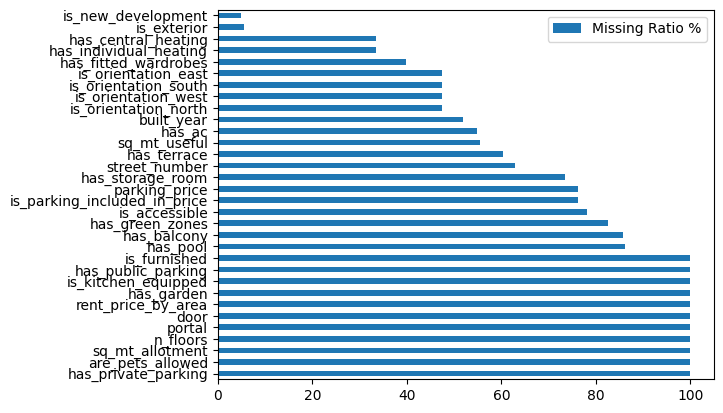

We're deleting only full null columns, then we're selecting only the columns we think are important for our case study.


In [27]:
# Coded originally found at https://stackoverflow.com/questions/69537383/how-to-plot-count-of-null-values-for-each-column-in-pandas-dataframe
def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100
        df = df.drop(na_df[na_df > 75].index, axis=1) # Drop columns full of NA values
        # na_df = na_df.drop(na_df[na_df > 99].index).sort_values(ascending=False)
        # missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        # missing_data.plot(kind = "barh")
        # plt.show()
        return df
    else:
        print('No NAs found')

def plot_nas_nulls(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100
        na_df = na_df.drop(na_df[na_df < 3].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh")
        plt.show()
        return df
    else:
        print('No NAs found')

print('First approach to null values.')
plot_nas_nulls(full_geocoded_houses)

print("We're deleting only full null columns, then we're selecting only the columns we think are important for our case study.")
plot_width, plot_height = (30,60)
cleaning_houses_df = plot_nas(full_geocoded_houses)

In [28]:
cleaning_houses_df['zip_code'] = cleaning_houses_df['zip_code'].astype(int)
cleaning_houses_df.drop('title', axis=1, inplace=True)
cleaning_houses_df.drop('is_exact_address_hidden', axis=1, inplace=True)
cleaning_houses_df = cleaning_houses_df.applymap(lambda x: 1 if x == True else x)
cleaning_houses_df = cleaning_houses_df.applymap(lambda x: 0 if x == False else x)
print(cleaning_houses_df.shape)

(8839, 46)


In [29]:
# Current columns
print(cleaning_houses_df.columns)

Index(['id', 'subtitle', 'sq_mt_built', 'sq_mt_useful', 'n_rooms',
       'n_bathrooms', 'raw_address', 'street_name', 'street_number', 'floor',
       'is_floor_under', 'neighborhood_id', 'operation', 'rent_price',
       'is_rent_price_known', 'buy_price', 'buy_price_by_area',
       'is_buy_price_known', 'house_type_id', 'is_renewal_needed',
       'is_new_development', 'built_year', 'has_central_heating',
       'has_individual_heating', 'has_ac', 'has_fitted_wardrobes', 'has_lift',
       'is_exterior', 'has_terrace', 'has_storage_room', 'energy_certificate',
       'has_parking', 'is_orientation_north', 'is_orientation_west',
       'is_orientation_south', 'is_orientation_east', 'full_title', 'zip_code',
       'latitude', 'longitude', 'zip_codes_count', 'hosts_count_per_zip_code',
       'hosts_distribution_per_zip_code', 'average_reviews_per_month_per_code',
       'price_per_m2', 'buy_for_rent_ratio'],
      dtype='object')


We're droping some of the columns we found here based on the idea que want to analyze, gentifrication, so basically we're finally droping: id, raw_addres (is similar to full title), street name, neighborhood_id, is_rent_pricec_known, buy_price_by_area (similar to price_per_m2), is_buy_price_known, house_type_id and energy_certificate.

In [32]:
final_selection_list = [
    'id', 'subtitle', 'sq_mt_built', 'sq_mt_useful', 'n_rooms',
    'n_bathrooms', 'floor',
    'is_floor_under', 'operation', 'buy_price', 'house_type_id', 'is_renewal_needed',
    'is_new_development', 'has_central_heating',
    'has_individual_heating', 'has_ac', 'has_fitted_wardrobes', 'has_lift',
    'is_exterior', 'has_terrace', 'has_storage_room', 'energy_certificate',
    'has_parking', 'full_title', 'zip_code',
    'latitude', 'longitude', 'zip_codes_count', 'hosts_count_per_zip_code',
    'hosts_distribution_per_zip_code', 'average_reviews_per_month_per_code',
    'price_per_m2', 'buy_for_rent_ratio'
]
clean_houses_df = cleaning_houses_df[final_selection_list]
clean_houses_df.head()

,id,subtitle,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,floor,is_floor_under,operation,buy_price,...,full_title,zip_code,latitude,longitude,zip_codes_count,hosts_count_per_zip_code,hosts_distribution_per_zip_code,average_reviews_per_month_per_code,price_per_m2,buy_for_rent_ratio
0,21742,SAN CRISTOBAL,64.0,60.0,2,1.0,3,0.0,sale,85000,...,"calle de Godella, 64, San Cristóbal, Madrid",28021,40.343172,-3.689091,94,70,0.255319,21.619672,1308.89,0.359847
1,21741,LOS ANGELES,70.0,NaN,3,1.0,4,0.0,sale,129900,...,"calle de la del Manojo de Rosas, Los Ángeles, ...",28041,40.355362,-3.697681,109,87,0.201835,25.850704,1796.68,0.370684
6,21698,LOS ANGELES,103.0,NaN,4,2.0,1,0.0,sale,171900,...,"calle de la del Manojo de Rosas, Los Ángeles, ...",28041,40.355362,-3.697681,109,87,0.201835,25.850704,1796.68,0.458067
11,21463,LOS ANGELES,65.0,NaN,2,1.0,Bajo,1.0,sale,109000,...,"calle de la del Manojo de Rosas, Los Ángeles, ...",28041,40.355362,-3.697681,109,87,0.201835,25.850704,1796.68,0.322261
16,21189,LOS ANGELES,72.0,68.0,2,1.0,3,0.0,sale,139000,...,"calle de la del Manojo de Rosas, Los Ángeles, ...",28041,40.355362,-3.697681,109,87,0.201835,25.850704,1796.68,0.390721


In [33]:
print(clean_houses_df.shape)
clean_houses_df.to_csv('datasets/houses_dataset_after_cleaning.csv')

(8839, 33)


Esta primera limpieza se ha basado, principalmente, en la eliminación de columnas que no eran de nuestro interés, así como otras columnas con un gran número de valores nulos que no aportaban información al conjunto global de los datos, funcionando casi como un valor constante (en este caso nulo). Se explicará en detalle en la memoria de la práctica. Posteriormente se continuará con el análisis del resto de valores nulos así como los valores extremos para, finalmente, realizar un estudio estadístico del conjunto de datos.